In [ ]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Handxray_Dataset/handxray')
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/My Drive/Handxray_Dataset/handxray


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import ast
from torch.nn.utils.rnn import pad_sequence


In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Load the DataFrame
file_path = 'VQA_QAEncoded.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Ensure question_encoded and answer_encoded are properly formatted
df['question_encoded'] = df['question_encoded'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['answer_encoded'] = df['answer_encoded'].astype(int)

In [ ]:
# Print unique answers and vocabulary size
print("Unique answer labels:", df['answer_encoded'].unique())
print("Answer vocabulary size:", len(df['answer_encoded'].unique()))

Unique answer labels: [0 1 2 3 4 5 6 7 8 9]
Answer vocabulary size: 10


In [ ]:
# Build question_vocab from unique tokens in questions
question_vocab = set(token for q in df['question_encoded'] for token in q)
question_vocab = {token: idx for idx, token in enumerate(question_vocab)}

In [ ]:
# Print question vocabulary size
print("Question vocab size:", len(question_vocab))

Question vocab size: 36


In [ ]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import torch

class VQADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load Image
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load Question and Answer
        question_encoded = self.dataframe.iloc[idx]['question_encoded']
        attention_mask = [1] * len(question_encoded)  # Assume full attention for non-padded tokens

        question = torch.tensor(question_encoded, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        answer = torch.tensor(self.dataframe.iloc[idx]['answer_encoded'], dtype=torch.long)

        return image, question, attention_mask, answer

def collate_fn(batch):
    images, input_ids, attention_masks, answers = zip(*batch)

    images = torch.stack(images)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    answers = torch.tensor(answers, dtype=torch.long)

    return images, input_ids, attention_masks, answers



In [ ]:
# Define transformations

#from torchvision import transforms

# Define transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet50 input
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image horizontally 50% of the time
    transforms.RandomRotation(degrees=10),  # Rotate image up to 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Random shift in image
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop with 80%-100% of the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])

#transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

In [ ]:
dataset = VQADataset(df, transform=transform)

In [ ]:
from torch.utils.data import DataLoader, random_split

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
#dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VQAModel(nn.Module):
    def __init__(self, hidden_size, answer_vocab_size, resnet_variant="resnet152", bert_model=None):
        super(VQAModel, self).__init__()

        # 🔹 Dynamically load the ResNet variant
        self.resnet = self._load_resnet(resnet_variant)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size)  # Replace the last layer

        # 🔹 BERT model for question encoding
        self.bert = bert_model  # Assumes a pre-initialized BERT model is passed in

        # 🔹 Classifier that combines image + text features
        self.fc = nn.Linear(hidden_size + 768, answer_vocab_size)

    def _load_resnet(self, variant):
        # Support multiple ResNet variants
        resnet_variants = {
            "resnet50": models.resnet50,
            "resnet101": models.resnet101,
            "resnet152": models.resnet152
        }

        if variant not in resnet_variants:
            raise ValueError(f"Unsupported ResNet variant: {variant}")

        print(f"Loading ResNet variant: {variant}")
        return resnet_variants[variant](pretrained=True)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.resnet(images)  # (batch_size, hidden_size)

        question_features = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        question_features = question_features[:, 0, :]  # (batch_size, 768)

        combined_features = torch.cat((image_features, question_features), dim=1)
        output = self.fc(combined_features)
        return output


In [ ]:
# class VQAModel(nn.Module):
#     def __init__(self, hidden_size, answer_vocab_size):
#         super(VQAModel, self).__init__()

#         # Use ResNet50 for image feature extraction
#         self.resnet = models.resnet50(pretrained=True)
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size)  # Keep this

#         # BERT for question processing
#         self.bert = bert_model

#         # Update `fc` to take the correct concatenated feature size
#         self.fc = nn.Linear(hidden_size + 768, answer_vocab_size)  # Update here

#     def forward(self, images, input_ids, attention_mask):
#         # Get image features
#         image_features = self.resnet(images)  # Shape: (batch_size, hidden_size)

#         # Get question features from BERT
#         question_features = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
#         question_features = question_features[:, 0, :]  # Shape: (batch_size, 768)

#         # Concatenate image and question features
#         combined_features = torch.cat((image_features, question_features), dim=1)  # Now (batch_size, hidden_size + 768)

#         # Get the final output (answer prediction)
#         output = self.fc(combined_features)

#         return output


In [ ]:
from transformers import BertModel

bert_model = BertModel.from_pretrained("bert-base-uncased")

model = VQAModel(
    hidden_size=256,
    answer_vocab_size=10,
    resnet_variant="resnet152",  # change this to any supported variant
    bert_model=bert_model
).to(device)

Loading ResNet variant: resnet152


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 150MB/s]


In [ ]:
# # Initialize model
# hidden_size = 256
# answer_vocab_size = 10  # As derived earlier
# model = VQAModel(hidden_size=hidden_size, answer_vocab_size=answer_vocab_size).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [ ]:
# Define optimizer and loss function
#optimizer = optim.Adam(model.parameters(), lr=0.001)
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs


import torch.nn.functional as F

# Compute class weights (inverse frequency)
#class_counts = df["answer_encoded"].value_counts().sort_index().to_numpy()
#class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
#class_weights = class_weights.to(device)
import torch

# Compute class weights (inverse frequency)
class_counts = df["answer_encoded"].value_counts().sort_index().to_numpy()
class_weights = 1.0 / (torch.tensor(class_counts, dtype=torch.float32) + 1e-4)  # Add small value to avoid division by zero
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = class_weights.to(device)

# Update loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

#criterion = nn.CrossEntropyLoss()

In [ ]:
print("Min label:", df['answer_encoded'].min())
print("Max label:", df['answer_encoded'].max())


In [ ]:
import torch
import matplotlib.pyplot as plt

# 🔹 Train Function with Loss Tracking
def train_bert_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0

        # 🔹 Training Loop
        for images, input_ids, attention_mask, answers in train_loader:
            images, input_ids, attention_mask, answers = (
                images.to(device),
                input_ids.to(device),
                attention_mask.to(device),
                answers.to(device),
            )

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)

            loss = criterion(outputs, answers)
            epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 🔹 Validation Loop (Testing)
        model.eval()
        epoch_test_loss = 0

        with torch.no_grad():
            for images, input_ids, attention_mask, answers in test_loader:
                images, input_ids, attention_mask, answers = (
                    images.to(device),
                    input_ids.to(device),
                    attention_mask.to(device),
                    answers.to(device),
                )

                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, answers)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Test Loss: {avg_test_loss:.4f}\n")

    # 🔹 Save Model
    torch.save(model.state_dict(), "bert_vqa_model.pth")
    print("Model saved as bert_vqa_model.pth")

    # 🔹 Plot Training & Validation Loss
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve (BERT Model)")
    plt.legend()
    plt.grid()
    plt.savefig("bert_loss_curve.png")
    plt.show()


Epoch [1/10]
Train Loss: 2.2879
Test Loss: 2.1220

Epoch [2/10]
Train Loss: 1.7788
Test Loss: 1.2535

Epoch [3/10]
Train Loss: 1.1418
Test Loss: 1.1046

Epoch [4/10]
Train Loss: 0.8059
Test Loss: 0.5846

Epoch [5/10]
Train Loss: 0.4808
Test Loss: 0.4170

Epoch [6/10]
Train Loss: 0.3741
Test Loss: 0.3333

Epoch [7/10]
Train Loss: 0.3262
Test Loss: 0.3520

Epoch [8/10]
Train Loss: 0.2767
Test Loss: 0.2554

Epoch [9/10]
Train Loss: 0.2387
Test Loss: 0.2608

Epoch [10/10]
Train Loss: 0.2175
Test Loss: 0.3067

Model saved as bert_vqa_model.pth


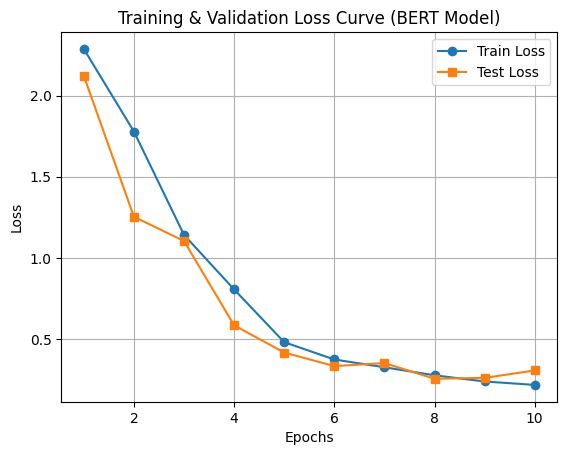

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_bert_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


In [ ]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, input_ids, attention_mask, answers in train_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, input_ids, attention_mask)

        # Compute loss
        loss = criterion(outputs, answers)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.3173
Epoch [2/10], Loss: 0.0870
Epoch [3/10], Loss: 0.0980
Epoch [4/10], Loss: 0.0221
Epoch [5/10], Loss: 0.1800
Epoch [6/10], Loss: 0.0107
Epoch [7/10], Loss: 0.0690
Epoch [8/10], Loss: 0.0333
Epoch [9/10], Loss: 0.0510
Epoch [10/10], Loss: 0.0305


In [ ]:
from nltk.corpus import wordnet
import numpy as np

def wup_similarity(pred, gt, threshold=0.8):
    #Compute Wu-Palmer Similarity between predicted and ground truth answers
    pred_synsets = wordnet.synsets(pred)
    gt_synsets = wordnet.synsets(gt)

    if not pred_synsets or not gt_synsets:
        return 0  # If no synsets are found, similarity is 0

    max_sim = max(wordnet.wup_similarity(p, g) or 0 for p in pred_synsets for g in gt_synsets)
    return 1 if max_sim >= threshold else max_sim

In [ ]:
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_loader, device, threshold=0.8):
    model.eval()
    all_results = []  # Store per-image results
    all_preds, all_labels, all_wups = [], [], []

    with torch.no_grad():
        for batch_idx, (images, input_ids, attention_masks, answers) in enumerate(test_loader):
            images, input_ids, attention_masks, answers = images.to(device), input_ids.to(device), attention_masks.to(device), answers.to(device)

            # 🔹 Get model outputs and apply Softmax for probabilities
            outputs = model(images, input_ids, attention_masks)
            probabilities = softmax(outputs, dim=1).cpu().numpy()  # Convert to NumPy array
            preds = np.argmax(probabilities, axis=1)

            labels = answers.cpu().numpy()

            # Compute WUPS for each prediction
            batch_wups = [wup_similarity(str(p), str(l), threshold) for p, l in zip(preds, labels)]
            all_wups.extend(batch_wups)

            # 🔹 Store results per image
            for i in range(len(images)):
                result = {
                    "image_index": batch_idx * len(images) + i,  # Unique index for each image
                    "true_label": labels[i],
                    "predicted_label": preds[i],
                    "class_probabilities": probabilities[i].tolist(),  # Convert to list for readability
                    "wups_score": batch_wups[i]
                }
                all_results.append(result)
                all_preds.append(preds[i])
                all_labels.append(labels[i])

    # Compute Overall Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    wups_score = np.mean(all_wups)

    # Print Overall Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"WUPS Score (Threshold {threshold}): {wups_score:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "wups": wups_score,
        "results_per_image": all_results  # ✅ Detailed per-image results
    }

# 🔹 Run Evaluation
metrics = evaluate_model(model, test_loader, device)

Accuracy: 0.9619
Precision: 0.9684
Recall: 0.9619
F1 Score: 0.9636
WUPS Score (Threshold 0.8): 1.0000


In [ ]:
import pandas as pd

df_results = pd.DataFrame(metrics["results_per_image"])
print(df_results.to_string(index=False))

 image_index  true_label  predicted_label                                                                                                                                                                                                                        class_probabilities  wups_score
           0           7                7        [0.0003702648391481489, 0.000336258060997352, 0.0003243430983275175, 0.0004622465930879116, 0.000648532179184258, 0.0004182185512036085, 0.0004844751092605293, 0.9963976740837097, 0.00035210413625463843, 0.00020587952167261392]           1
           1           0                0      [0.9960274696350098, 0.0004547024436760694, 0.0010375394485890865, 0.0003241205704398453, 0.0007722149603068829, 0.0002749041887000203, 0.00013882566418033093, 0.0004489567072596401, 0.0003655239997897297, 0.00015587198140565306]           1
           2           0                0     [0.9962882995605469, 0.00037358689587563276, 0.00012052546662744135, 0.0003984164504799

In [ ]:
#####Verification to figure out why accuracy is low


 #class distribution/imbalance

import matplotlib.pyplot as plt

# Check the distribution of answer labels
answer_counts = df['answer_encoded'].value_counts()
print(answer_counts)

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(answer_counts.index, answer_counts.values)
plt.xlabel("Answer Classes")
plt.ylabel("Count")
plt.title("Class Distribution in Training Data")
plt.show()


In [ ]:
#Are predictions random or biased

model.eval()
with torch.no_grad():
    images, input_ids, attention_mask, answers = next(iter(dataloader))
    images, input_ids, attention_mask, answers = images.to(device), input_ids.to(device), attention_mask.to(device), answers.to(device)

    outputs = model(images, input_ids, attention_mask)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1)

    print("Predicted labels:", predicted_labels.cpu().numpy())
    print("True labels:", answers.cpu().numpy())

    # Check how many unique predictions the model is making
    print("Unique predicted classes:", set(predicted_labels.cpu().numpy()))


Predicted labels: [8 5 6 2 4 0 7 3 6 7 9 7 8 1 7 1 0 7 4 5 0 0 7 0 0 6 1 5 0 6 8 6]
True labels: [8 5 6 6 4 0 7 3 6 7 4 7 8 1 7 1 0 7 4 5 0 0 7 0 0 6 1 5 0 6 8 6]
Unique predicted classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
